In [1]:
import cv2, numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max

(356, 493)


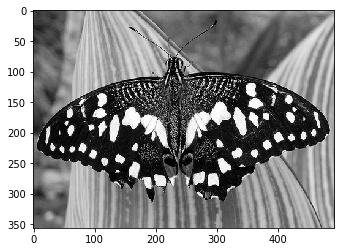

In [190]:
imgName = "butterfly"
imgRgb = cv2.imread(imgName+".jpg")
img = cv2.cvtColor(imgRgb, cv2.COLOR_BGR2GRAY)/255
n,m=img.shape
print(img.shape)
plt.imshow(img,cmap="gray")

In [191]:
def LOG(sigma):
    size = int(sigma*6)
    size = size + 1 if(size%2==0) else size
    log = np.zeros((size, size))
    centerX = int(size/2)
    centerY = int(size/2)
    def getVal(x, y):
        return ((x-centerX)**2 + (y-centerY)**2 - 2*(sigma**2))*np.exp(-((x-centerX)**2 + (y-centerY)**2)/(2*(sigma**2)))
    log = [[getVal(x, y)*(sigma**2) for y in range(size)] for x in range(size)]
    return np.array(log)

In [192]:
def convolveImg(img, log):
    M, N = img.shape
    ans = np.zeros((M, N))
    #res = np.zeros((M+X, N+Y))
    w = log.shape[0]
    w_pad = int(w/2)
    padImg = np.pad(img, (w_pad, w_pad), mode = 'constant')
    
    for i, j in np.ndindex(ans.shape):
        ans[i, j] = np.sum(np.multiply(padImg[i:i+w, j:j+w], log))
        #res[i, j] = ans[i, j]/np.sum(log)
    return np.square(ans)

def getResponse(img, sigma, k, numbers = 10):
    responses = []
    M, N = img.shape
    
    for _ in range(numbers):
        print(sigma)
        log = LOG(sigma)
        conv = convolveImg(img, log)
        #np.concatenate(conv, np.zeros(M, padY))
        responses.append(conv)
        plt.imshow(conv, cmap="gray")
        plt.figure()
        sigma *= k
    return np.array(responses)

In [ ]:
K = 1.2509
sigma = 4 #einstein=4, 1.2509
num_scales = 10
responses = getResponse(img, sigma, K, num_scales)
responses.shape

4
5.0036
6.259003239999999
7.829387152915999
9.793780389582622
12.2510398893289
15.324825797561521
19.169824590169707
23.979533579843284
29.995998555025963


In [ ]:
def getMaxes(img, st_dev, K, conv):
    copy = img.copy()
    radius = np.zeros([img.shape[0], img.shape[1]])
    for k in range(num_scales):
        s = int(st_dev*6)
        s = s + 1 if(s%2==0) else s
        coordinates = peak_local_max(conv[k], min_distance=(k+1)*5)
        for i in coordinates:
            cv2.circle(copy,(i[1],i[0]), int(st_dev*np.sqrt(2)), (255,0,0), 2)
            radius[i[0],i[1]] = s

        st_dev*=K
        cv2.imwrite("out_"+imgName+"_before_NMS.jpg",copy)
        plt.imshow(copy)
    return radius
    
rad_matrix = getMaxes(imgRgb, sigma, K, responses)

In [ ]:
def nonMax(radius):
    n, m = radius.shape
    for i, j in np.ndindex(n, m):
        if radius[i,j] != 0:
            wsize=int(radius[i,j]/2)-int(radius[i,j]/3)
            for i1 in range(i-wsize,i+wsize):
                for j1 in range(j-wsize,j+wsize):
                    #if (i1>=0 and i1<n) and (j1>=0 and j1<m):
                    if radius[i1,j1] < radius[i,j]:
                        radius[i1,j1]=0
    return radius

rad_matix = nonMax(rad_matrix)

In [ ]:
copy=imgRgb.copy()
for i in range(n):
    for j in range(m):
        if rad_matrix[i,j]!=0:
            cv2.circle(copy, (j,i), int((rad_matrix[i,j]/7)*np.sqrt(2)), (0,0,255), 2)
plt.imshow(copy)
cv2.imwrite("out_"+imgName+".jpg",copy)